### 1. Recap of the Previous Phase
From the previous modeling on actual store transactions, we drew the following conclusions:
- Random Forest (RF) outperformed all other models with minimal effort in fine-tuning hyperparameters, although its computation time is significantly longer.
- Linear Regression's most important features are store_trans, GroceryI, store type A, onpromotion, year, cluster5, Cleaning, and daily oil price. Both Decision Tree (DT) and Random Forest identified store_trans, GroceryI, Beverages, onpromotion, daily oil price, year, month, and Produce as their top features. There are minor differences between DT and RF.
- Error Analysis:
High density near zero, suggesting that the model is generally accurate.
A long right tail, indicating that the model significantly underestimates some actual values due to remaining outliers in the dataset.
- After removing the 5 extreme outliers, the test R² jumped from 0.91 to 0.96.
- The model performs best when sales units are below 8,343. Its performance decreases when sales units are between 8,344 and 38,422, and it performs poorly when sales units exceed 38,422.
### 2. Objectives for the Current Phase
Based on the conclusions, we should take the following actions:
- Use Random Forest to model the forecasted dataset, as the forecasted data closely resembles the actual data.
- Remove the 5 extreme outliers.
- Apply the fine-tuned hyperparameters to the new dataset, as it closely matches the actual data.


In [118]:
# import basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl

### 3. Preprocessing

- Read the forcasted dataframe and drop the added rows on Christmas Days since
- Read the "filled_store_trans.csv" as it contains full information before getting dummy variables.
- Join the above two tables so that the full data contains all the columns needed for modeling.

In [119]:
# read data
df_pred =pd.read_csv("df_store_trans_pred.csv")
df_pred.head()

,date,store_nbr,store_promo,year,month,day,dcoilwtico_interpolated,store_trans_filled,weekday,weekend,lag365,store_trans_pred
0,2014-01-02,1,0.0,2014.0,1.0,2.0,95.14,1875.0,4.0,0.0,2111.0,NaN
1,2014-01-03,1,0.0,2014.0,1.0,3.0,93.66,1817.0,5.0,0.0,1833.0,NaN
2,2014-01-04,1,0.0,2014.0,1.0,4.0,93.48,1294.0,0.0,1.0,1863.0,NaN
3,2014-01-05,1,0.0,2014.0,1.0,5.0,93.30,489.0,0.0,1.0,1509.0,NaN
4,2014-01-06,1,0.0,2014.0,1.0,6.0,93.12,1754.0,1.0,0.0,520.0,NaN


In [120]:
df_pred.store_nbr.nunique()

17

In [121]:
# read data
df=pd.read_csv("filled_store_trans.csv")
df

,date,store_nbr,family,sales,onpromotion,store_promo,sto_type,cluster,holi_type,locale,description_eng,year,month,day,dcoilwtico_interpolated,store_trans_filled
0,2013-01-02,1,BEVERAGES,1091.000,0,0,D,13,NaN,NaN,NaN,2013,1,2,93.14,2111.0
1,2013-01-02,1,CLEANING,1060.000,0,0,D,13,NaN,NaN,NaN,2013,1,2,93.14,2111.0
2,2013-01-02,1,DAIRY,579.000,0,0,D,13,NaN,NaN,NaN,2013,1,2,93.14,2111.0
3,2013-01-02,1,GROCERY I,2652.000,0,0,D,13,NaN,NaN,NaN,2013,1,2,93.14,2111.0
4,2013-01-02,1,PRODUCE,0.000,0,0,D,13,NaN,NaN,NaN,2013,1,2,93.14,2111.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143385,2017-08-15,9,BEVERAGES,3530.000,26,331,B,6,NaN,NaN,NaN,2017,8,15,47.57,2155.0
143386,2017-08-15,9,CLEANING,1439.000,25,331,B,6,NaN,NaN,NaN,2017,8,15,47.57,2155.0
143387,2017-08-15,9,DAIRY,835.000,19,331,B,6,NaN,NaN,NaN,2017,8,15,47.57,2155.0
143388,2017-08-15,9,GROCERY I,6630.383,62,331,B,6,NaN,NaN,NaN,2017,8,15,47.57,2155.0


In [122]:
df.store_nbr.nunique()

17

In [123]:
# check for null values in df
df_null = df[df.store_trans_filled.isna()]
print(df_null.store_nbr.unique())
print(df_null.date.min())
print(df_null.date.max())

[20]
2013-01-02
2015-02-12


In [124]:
df_null

,date,store_nbr,family,sales,onpromotion,store_promo,sto_type,cluster,holi_type,locale,description_eng,year,month,day,dcoilwtico_interpolated,store_trans_filled
20,2013-01-02,20,BEVERAGES,0.0,0,0,B,6,NaN,NaN,NaN,2013,1,2,93.14,NaN
21,2013-01-02,20,CLEANING,0.0,0,0,B,6,NaN,NaN,NaN,2013,1,2,93.14,NaN
22,2013-01-02,20,DAIRY,0.0,0,0,B,6,NaN,NaN,NaN,2013,1,2,93.14,NaN
23,2013-01-02,20,GROCERY I,0.0,0,0,B,6,NaN,NaN,NaN,2013,1,2,93.14,NaN
24,2013-01-02,20,PRODUCE,0.0,0,0,B,6,NaN,NaN,NaN,2013,1,2,93.14,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65470,2015-02-12,20,BEVERAGES,0.0,0,0,B,6,NaN,NaN,NaN,2015,2,12,51.17,NaN
65471,2015-02-12,20,CLEANING,0.0,0,0,B,6,NaN,NaN,NaN,2015,2,12,51.17,NaN
65472,2015-02-12,20,DAIRY,0.0,0,0,B,6,NaN,NaN,NaN,2015,2,12,51.17,NaN
65473,2015-02-12,20,GROCERY I,0.0,0,0,B,6,NaN,NaN,NaN,2015,2,12,51.17,NaN


#### Since the null values in df is caused by late opening of store 20, we can drop the null rows as these rows are not our concerns.

In [125]:
# Drop the nulls caused by store 20 late opening
df = df[~((df.store_nbr == 20) & (df.store_trans_filled.isna()))]
df

,date,store_nbr,family,sales,onpromotion,store_promo,sto_type,cluster,holi_type,locale,description_eng,year,month,day,dcoilwtico_interpolated,store_trans_filled
0,2013-01-02,1,BEVERAGES,1091.000,0,0,D,13,NaN,NaN,NaN,2013,1,2,93.14,2111.0
1,2013-01-02,1,CLEANING,1060.000,0,0,D,13,NaN,NaN,NaN,2013,1,2,93.14,2111.0
2,2013-01-02,1,DAIRY,579.000,0,0,D,13,NaN,NaN,NaN,2013,1,2,93.14,2111.0
3,2013-01-02,1,GROCERY I,2652.000,0,0,D,13,NaN,NaN,NaN,2013,1,2,93.14,2111.0
4,2013-01-02,1,PRODUCE,0.000,0,0,D,13,NaN,NaN,NaN,2013,1,2,93.14,2111.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143385,2017-08-15,9,BEVERAGES,3530.000,26,331,B,6,NaN,NaN,NaN,2017,8,15,47.57,2155.0
143386,2017-08-15,9,CLEANING,1439.000,25,331,B,6,NaN,NaN,NaN,2017,8,15,47.57,2155.0
143387,2017-08-15,9,DAIRY,835.000,19,331,B,6,NaN,NaN,NaN,2017,8,15,47.57,2155.0
143388,2017-08-15,9,GROCERY I,6630.383,62,331,B,6,NaN,NaN,NaN,2017,8,15,47.57,2155.0


#### We are sure that both datasets contain 17 stores sales data and we need to join the two tables for modeling.

In [126]:
df_actual_and_pred = pd.merge(
    df, 
    df_pred, 
    how='left', 
    on=['date', 'store_nbr'], 
    suffixes=('_a', '_p')
)
df_actual_and_pred

,date,store_nbr,family,sales,onpromotion,store_promo_a,sto_type,cluster,holi_type,locale,...,store_promo_p,year_p,month_p,day_p,dcoilwtico_interpolated_p,store_trans_filled_p,weekday,weekend,lag365,store_trans_pred
0,2013-01-02,1,BEVERAGES,1091.000,0,0,D,13,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,CLEANING,1060.000,0,0,D,13,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-02,1,DAIRY,579.000,0,0,D,13,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-02,1,GROCERY I,2652.000,0,0,D,13,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-02,1,PRODUCE,0.000,0,0,D,13,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139530,2017-08-15,9,BEVERAGES,3530.000,26,331,B,6,NaN,NaN,...,331.0,2017.0,8.0,15.0,47.57,2155.0,2.0,0.0,1999.0,1947.103475
139531,2017-08-15,9,CLEANING,1439.000,25,331,B,6,NaN,NaN,...,331.0,2017.0,8.0,15.0,47.57,2155.0,2.0,0.0,1999.0,1947.103475
139532,2017-08-15,9,DAIRY,835.000,19,331,B,6,NaN,NaN,...,331.0,2017.0,8.0,15.0,47.57,2155.0,2.0,0.0,1999.0,1947.103475
139533,2017-08-15,9,GROCERY I,6630.383,62,331,B,6,NaN,NaN,...,331.0,2017.0,8.0,15.0,47.57,2155.0,2.0,0.0,1999.0,1947.103475


In [127]:
df_actual_and_pred.columns 

Index(['date', 'store_nbr', 'family', 'sales', 'onpromotion', 'store_promo_a',
       'sto_type', 'cluster', 'holi_type', 'locale', 'description_eng',
       'year_a', 'month_a', 'day_a', 'dcoilwtico_interpolated_a',
       'store_trans_filled_a', 'store_promo_p', 'year_p', 'month_p', 'day_p',
       'dcoilwtico_interpolated_p', 'store_trans_filled_p', 'weekday',
       'weekend', 'lag365', 'store_trans_pred'],
      dtype='object')

In [128]:
# Sanity check to make sure the join is correct
df_actual_and_pred_2014 = df_actual_and_pred[df_actual_and_pred['date'] >= '2014-01-01']
mismatches = df_actual_and_pred_2014[df_actual_and_pred_2014['store_trans_filled_a'] != df_actual_and_pred_2014['store_trans_filled_p']]
m = mismatches.loc[:,['date','store_nbr','family','store_trans_filled_a','store_trans_filled_p']]
# Check on what dates the data are are missmatched
for store in list(df_actual_and_pred['store_nbr'].unique()):
    mismatches = m[m['store_nbr'] == store]
    mismatch_dates = mismatches['date'].unique()
    if len(mismatch_dates) > 0:
        print(f'Store {store} mismatched on {list(mismatch_dates)}')

Store 1 mismatched on ['2014-01-01']
Store 10 mismatched on ['2014-01-01']
Store 17 mismatched on ['2014-01-01']
Store 2 mismatched on ['2014-01-01']
Store 3 mismatched on ['2014-01-01']
Store 4 mismatched on ['2014-01-01']
Store 44 mismatched on ['2014-01-01']
Store 45 mismatched on ['2014-01-01']
Store 46 mismatched on ['2014-01-01']
Store 47 mismatched on ['2014-01-01']
Store 48 mismatched on ['2014-01-01']
Store 49 mismatched on ['2014-01-01']
Store 6 mismatched on ['2014-01-01']
Store 7 mismatched on ['2014-01-01']
Store 8 mismatched on ['2014-01-01']
Store 9 mismatched on ['2014-01-01']
Store 20 mismatched on ['2015-02-13', '2015-02-14', '2015-02-15', '2015-02-16', '2015-02-17', '2015-02-18', '2015-02-19', '2015-02-20', '2015-02-21', '2015-02-22', '2015-02-23', '2015-02-24', '2015-02-25', '2015-02-26', '2015-02-27', '2015-02-28', '2015-03-01', '2015-03-02', '2015-03-03', '2015-03-04', '2015-03-05', '2015-03-06', '2015-03-07', '2015-03-08', '2015-03-09', '2015-03-10', '2015-03-11'

#### Tracing back, we can see that the missmatches were caused by two reasons:
1. For all stores, due to the fact that stores closed on Jan 1st of every year and the 'store_trans_filled_a' have data but the matching 'store_trans_filled_p' doesn't have is due to the fillna method applied on df_actual. Since Machine Leaning models don't require continuous time series dataset, we can drop all the rows of Jan 1st, 2014.
2. The mismatches of store 20 is caused due to dropna of 'Lag365' column, so we need to use 'store_trans_filled_a' instead of 'store_trans_filled_p' to avoid loss of data.

In [129]:
# Drop rows of New Year Day(Jan 1st) as stores don't open on Jan 1st and the data were filled to achieve continuaty for Time Series.
dates_to_remove = ['2013-01-01', '2014-01-01', '2015-01-01', '2016-01-01', '2017-01-01']
df_actual_and_pred = df_actual_and_pred[~df_actual_and_pred['date'].isin(dates_to_remove)]
# Drop duplicated and unneccessary columns
cols = ['store_promo_a','store_promo_p', 'year_p', 'month_p', 'day_p', 'dcoilwtico_interpolated_p', 'store_trans_filled_p','lag365']
df_actual_and_pred = df_actual_and_pred.drop(columns=cols)
df_actual_and_pred

,date,store_nbr,family,sales,onpromotion,sto_type,cluster,holi_type,locale,description_eng,year_a,month_a,day_a,dcoilwtico_interpolated_a,store_trans_filled_a,weekday,weekend,store_trans_pred
0,2013-01-02,1,BEVERAGES,1091.000,0,D,13,NaN,NaN,NaN,2013,1,2,93.14,2111.0,NaN,NaN,NaN
1,2013-01-02,1,CLEANING,1060.000,0,D,13,NaN,NaN,NaN,2013,1,2,93.14,2111.0,NaN,NaN,NaN
2,2013-01-02,1,DAIRY,579.000,0,D,13,NaN,NaN,NaN,2013,1,2,93.14,2111.0,NaN,NaN,NaN
3,2013-01-02,1,GROCERY I,2652.000,0,D,13,NaN,NaN,NaN,2013,1,2,93.14,2111.0,NaN,NaN,NaN
4,2013-01-02,1,PRODUCE,0.000,0,D,13,NaN,NaN,NaN,2013,1,2,93.14,2111.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139530,2017-08-15,9,BEVERAGES,3530.000,26,B,6,NaN,NaN,NaN,2017,8,15,47.57,2155.0,2.0,0.0,1947.103475
139531,2017-08-15,9,CLEANING,1439.000,25,B,6,NaN,NaN,NaN,2017,8,15,47.57,2155.0,2.0,0.0,1947.103475
139532,2017-08-15,9,DAIRY,835.000,19,B,6,NaN,NaN,NaN,2017,8,15,47.57,2155.0,2.0,0.0,1947.103475
139533,2017-08-15,9,GROCERY I,6630.383,62,B,6,NaN,NaN,NaN,2017,8,15,47.57,2155.0,2.0,0.0,1947.103475


In [130]:
# Convert 'date' column to datetime type
df_actual_and_pred['date'] = pd.to_datetime(df_actual_and_pred['date'])

# Feature engineering 'weekday' and 'weekend' columns
df_actual_and_pred["weekday"] = np.where(df_actual_and_pred["date"].dt.weekday < 5, df_actual_and_pred["date"].dt.weekday + 1, 0)
df_actual_and_pred["weekend"] = np.where(df_actual_and_pred["date"].dt.weekday >= 5, 1, 0)

# Display the DataFrame
df_actual_and_pred

,date,store_nbr,family,sales,onpromotion,sto_type,cluster,holi_type,locale,description_eng,year_a,month_a,day_a,dcoilwtico_interpolated_a,store_trans_filled_a,weekday,weekend,store_trans_pred
0,2013-01-02,1,BEVERAGES,1091.000,0,D,13,NaN,NaN,NaN,2013,1,2,93.14,2111.0,3,0,NaN
1,2013-01-02,1,CLEANING,1060.000,0,D,13,NaN,NaN,NaN,2013,1,2,93.14,2111.0,3,0,NaN
2,2013-01-02,1,DAIRY,579.000,0,D,13,NaN,NaN,NaN,2013,1,2,93.14,2111.0,3,0,NaN
3,2013-01-02,1,GROCERY I,2652.000,0,D,13,NaN,NaN,NaN,2013,1,2,93.14,2111.0,3,0,NaN
4,2013-01-02,1,PRODUCE,0.000,0,D,13,NaN,NaN,NaN,2013,1,2,93.14,2111.0,3,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139530,2017-08-15,9,BEVERAGES,3530.000,26,B,6,NaN,NaN,NaN,2017,8,15,47.57,2155.0,2,0,1947.103475
139531,2017-08-15,9,CLEANING,1439.000,25,B,6,NaN,NaN,NaN,2017,8,15,47.57,2155.0,2,0,1947.103475
139532,2017-08-15,9,DAIRY,835.000,19,B,6,NaN,NaN,NaN,2017,8,15,47.57,2155.0,2,0,1947.103475
139533,2017-08-15,9,GROCERY I,6630.383,62,B,6,NaN,NaN,NaN,2017,8,15,47.57,2155.0,2,0,1947.103475


In [131]:
# Drop 'date
df_actual_and_pred = df_actual_and_pred.drop(columns='date')

In [132]:
# Check for nulls
df_actual_and_pred.isna().sum()

store_nbr                         0
family                            0
sales                             0
onpromotion                       0
sto_type                          0
cluster                           0
holi_type                    127270
locale                       127270
description_eng              127270
year_a                            0
month_a                           0
day_a                             0
dcoilwtico_interpolated_a         0
store_trans_filled_a              0
weekday                           0
weekend                           0
store_trans_pred             119995
dtype: int64

#### We need to fill the nulls of 'store_trans_pred' with the corresponding values of 'store_trans_filled_a' as these two columns represent one feature and 'store_trans_pred' is the prediction of 'store_trans_filled_a'

In [133]:
# Fill nulls in 'store_trans_pred' with values from 'store_trans_filled_a'
df_actual_and_pred['store_trans_pred'] = df_actual_and_pred['store_trans_pred'].fillna(value=df_actual_and_pred['store_trans_filled_a'])
# Check for nulls
df_actual_and_pred.isna().sum()

store_nbr                         0
family                            0
sales                             0
onpromotion                       0
sto_type                          0
cluster                           0
holi_type                    127270
locale                       127270
description_eng              127270
year_a                            0
month_a                           0
day_a                             0
dcoilwtico_interpolated_a         0
store_trans_filled_a              0
weekday                           0
weekend                           0
store_trans_pred                  0
dtype: int64

In [134]:
# Sanity check of the filled column
df_sanity = df_actual_and_pred.loc[df_actual_and_pred.store_trans_filled_a==df_actual_and_pred.store_trans_pred]
print(f"{df_sanity.year_a.unique()}")
df_sanity = df_actual_and_pred.loc[df_actual_and_pred.store_trans_filled_a!=df_actual_and_pred.store_trans_pred]
print(f"{df_sanity.year_a.unique()}")

[2013 2014 2015 2016]
[2017]


#### We can see that the 'store_trans_pred' has been properly filled. Let's drop 'store_trans_filled_a' as it is duplicated.

In [135]:
df_actual_and_pred = df_actual_and_pred.drop(columns='store_trans_filled_a')
df_actual_and_pred.head()

,store_nbr,family,sales,onpromotion,sto_type,cluster,holi_type,locale,description_eng,year_a,month_a,day_a,dcoilwtico_interpolated_a,weekday,weekend,store_trans_pred
0,1,BEVERAGES,1091.0,0,D,13,NaN,NaN,NaN,2013,1,2,93.14,3,0,2111.0
1,1,CLEANING,1060.0,0,D,13,NaN,NaN,NaN,2013,1,2,93.14,3,0,2111.0
2,1,DAIRY,579.0,0,D,13,NaN,NaN,NaN,2013,1,2,93.14,3,0,2111.0
3,1,GROCERY I,2652.0,0,D,13,NaN,NaN,NaN,2013,1,2,93.14,3,0,2111.0
4,1,PRODUCE,0.0,0,D,13,NaN,NaN,NaN,2013,1,2,93.14,3,0,2111.0


In [139]:
# Get the dummy variables
df_actual_and_pred_dummy = pd.get_dummies(df_actual_and_pred,columns=['store_nbr','family','sto_type','cluster','holi_type','locale','description_eng'], dtype='int')
df_actual_and_pred_dummy.head()

,sales,onpromotion,year_a,month_a,day_a,dcoilwtico_interpolated_a,weekday,weekend,store_trans_pred,store_nbr_1,...,description_eng_WORLD OF FOOTBALL BRAZIL: ECUADOR-HONDURAS,description_eng_WORLD OF FOOTBALL BRAZIL: ECUADOR-SUIZA,description_eng_WORLD OF FOOTBALL BRAZIL: Ecuador-France,description_eng_WORLD OF FOOTBALL BRAZIL: Eighth of Final,description_eng_WORLD OF FOOTBALL BRAZIL: FINAL,description_eng_World Cup Brazil: Quarter Final,description_eng_World Cup Brazil: Semifinals,description_eng_World Cup Brazil: Third and fourth place,description_eng_World Football Inauguration Brazil,description_eng_foundation of Quito
0,1091.0,0,2013,1,2,93.14,3,0,2111.0,1,...,0,0,0,0,0,0,0,0,0,0
1,1060.0,0,2013,1,2,93.14,3,0,2111.0,1,...,0,0,0,0,0,0,0,0,0,0
2,579.0,0,2013,1,2,93.14,3,0,2111.0,1,...,0,0,0,0,0,0,0,0,0,0
3,2652.0,0,2013,1,2,93.14,3,0,2111.0,1,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0,2013,1,2,93.14,3,0,2111.0,1,...,0,0,0,0,0,0,0,0,0,0


In [140]:
# Drop the dummy variables containg the least information
drop_cols = ['family_DAIRY', 'store_nbr_20', 'description_eng_WORLD OF FOOTBALL BRAZIL: ECUADOR-HONDURAS', 'sto_type_C', 'cluster_5', 'holi_type_Bridge']
df_actual_and_pred_clean = df_actual_and_pred_dummy.drop(columns=drop_cols)
df_actual_and_pred_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 139205 entries, 0 to 139534
Columns: 115 entries, sales to description_eng_foundation of Quito
dtypes: float64(3), int32(108), int64(4)
memory usage: 65.8 MB


### 4. Modeling

- Split the dataset

In [141]:
# Training set: Data where 'year_a' is less than 2017
df_train = df_actual_and_pred_clean[df_actual_and_pred_clean.year_a < 2017]
# Test set: Data where 'year_a' is 2017 or later
df_test = df_actual_and_pred_clean[df_actual_and_pred_clean.year_a >= 2017]
X_train = df_train.drop("sales", axis=1)
y_train = df_train["sales"]

X_test = df_test.drop("sales", axis=1)
y_test = df_test["sales"]

### Since we have used similar data and generated a robust model, I will skip the hyperparameter fine tuning part and apply the best parameters from last time to train and test the dataset.

In [142]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [143]:
# Initialize and train the RandomForestRegressor
rf = RandomForestRegressor(random_state=42, max_depth=40, min_samples_leaf=5, n_estimators=300)
rf.fit(X_train, y_train)

# Make predictions
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# Calculate and print metrics for training data
print(f"Train R² score: {r2_score(y_train, y_train_pred):.2f}")
print(f"Train MAE: {mean_absolute_error(y_train, y_train_pred):.2f}")
print(f"Train MSE: {mean_squared_error(y_train, y_train_pred):.2f}")

# Calculate and print metrics for test data
print(f"Test R² score: {r2_score(y_test, y_test_pred):.2f}")
print(f"Test MAE: {mean_absolute_error(y_test, y_test_pred):.2f}")
print(f"Test MSE: {mean_squared_error(y_test, y_test_pred):.2f}")

Train R² score: 0.97
Train MAE: 200.28
Train MSE: 224132.66
Test R² score: 0.89
Test MAE: 606.63
Test MSE: 1384237.80


#### Given that the training was performed on real store transactions and testing was conducted on time series-predicted store transactions, the model achieved a test R² score of 0.89. This high R² score suggests that the model is robust and performs well on the forecast of store category sales quantities. We can conclude that the model is effective for predicting sales quantities in the store category.

### 5. Model Evaluation

- 5.1 Feature Importance

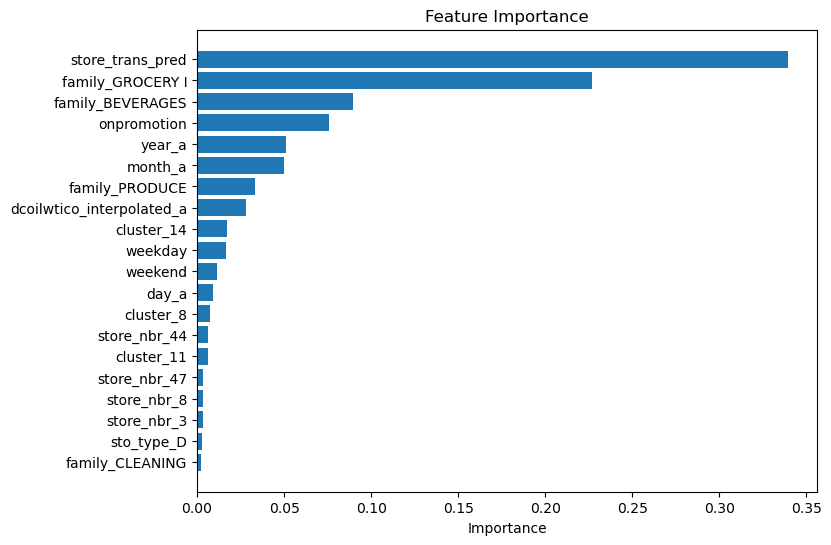

In [144]:
# Check for important features of the best model
feature_importances = rf.feature_importances_
features = X_train.columns

# Create a DataFrame for better visualization
feature_df = pd.DataFrame({'feature': features, 'importance': feature_importances})
feature_df = feature_df.sort_values(by='importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(8, 6))
plt.barh(feature_df['feature'][:20], feature_df['importance'][:20])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

#### 5.2 Error Analysis

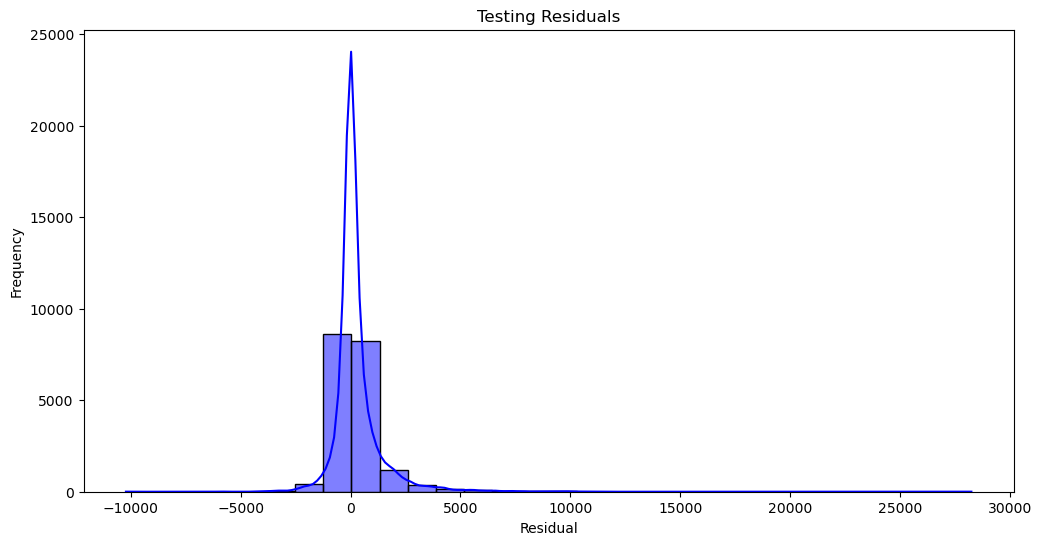

In [145]:
# Calculate residuals
test_residuals = y_test - y_test_pred

# Plot residuals
plt.figure(figsize=(12, 6))
sns.histplot(test_residuals, kde=True, bins=30, color='blue')
plt.title('Testing Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

#### The residual plot shows that most residuals fall between -600 and 600, indicating that the model predicts fairly accurately for most data points. The right-skewed distribution suggests the presence of large positive outliers, which the model failed to capture. Overall, the majority of residuals are within a narrow range, reflecting that the model performs well for the bulk of the data.